# PyOAE - Example calculation of the hypothetical maximum OAE efficiency ($\eta$max)

by Greg Pelletier, 01-Feb-2025

This notebook presents a new function "etamax" to calculate the hypothetical maximum OAE efficiency ($\eta$max) for an assumed alkalinity treatment addition ($\Delta$TA). The potential maximum CDR is also calculated with $\eta$max, and these two variables are related to each other as follows:

- $\eta$max = CDRpot / $\Delta$TA = the hypothetical maximum OAE efficiency "etamax", typically in the range of 0.7-0.9 (dimensionless)

where CDRpot is the hypothetical maximumum potential CDR corresponding to the OAE treatment.

Inputs to the "etamax" function are as follows:

- dTA = $\Delta$TA addition of alkalinity due to OAE (umol/kg)
- TA_ctl = control TA before OAE treatment (umol/kg)
- DIC_ctl = control DIC before OAE treatment (umol/kg)
- SiO3_ctl = control SiO3 (umol/kg)
- PO4_ctl = control PO4 at time before OAE treatment (umol/kg)
- Temp_ctl = control temperature ($^\circ$C)
- Sal_ctl = control salinity (psu)
- Pres_ctl = control pressure (dbar)

The "etamax" function calculates the following variables using PyCO2SYS:

- Step 1: Calculate pCO2 at control conditions (pCO2_ctl in uatm) using inputs of TA_ctl and DIC_ctl as inputs

- Step 2: Calculate DIC_eq, CDR_pot, and etamax using inputs of TA= TA_ctl + dTA and pCO2 at control conditions, defined as follows:
    - DIC_eq = PyCO2SYS calculation of DIC at equilibrium when input TA= TA_ctl + dTA and input pCO2= pCO2t_ctl
    - CDR_pot = DIC_eq - DIC_ctl = hypothetical maximum potential CDR (umol/kg)
    - etamax = CDR_pot / dTA = hypothetical maximum OAE efficiency, typically in the range of 0.7-0.9 (dimensionless)

The "etamax" function returns a data dictionary of outputs including etamax, CDR_pot, DIC_eq, and pCO2_ctl


## Import the packages that are needed

In [21]:
import numpy as np
import PyCO2SYS as pyco2
import xarray as xr
import dask.array as da
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
%matplotlib inline
import time

## Define the function f_dTA to be used with brentq to find the root

In [22]:
def etamax(dTA, TA_ctl, DIC_ctl, SiO3_ctl, PO4_ctl, Temp_ctl, Sal_ctl, Pres_ctl):

    """
    PURPOSE

    Calculate the hypothetical maximum OAE efficiency "etamax" for an assumed alkalinity treatment addition "dTA"
    and control conditions of TA, DIC, SiO3, PO4, temperature, and salinity
  
    EXAMPLE USAGE

    # import the packages that are needed
    import numpy as np
    from PyOAE import etamax
    # assign the inputs that are needed
    dTA = 1   # lower bound of the range of dTA values (umol/kg) to search for the root
    TA = 2232
    DIC = 1861
    SiO3 = 1.346
    PO4 = 0.201
    Temp = 26.683
    Sal = 34.004
    Pres = 0
    # call the etamax function
    result = etamax(dTA, TA, DIC, SiO3, PO4, Temp, Sal, Pres)
    result

    INPUTS

    dTA = assumed value of the added concentration of TA due to OAE treatment (umol/kg)
    TA = control TA before OAE addition (umol/kg)
    DIC = control DIC before OAE addition (umol/kg)
    SiO3 = control SiO3 (umol/kg)
    PO4 = control PO4 (umol/kg)
    Temp = control temperature (degC)
    Sal = control salinity (psu)
    Pres = control pressure (dbar)

    OUTPUTS 

    - result = dictionary of output varlables with the following keys:
        - 'etamax': hypothetical maximum OAE efficiency (dimensionless)
        - 'CDR_pot': hypothetical maximum potential CDR (umol/kg)
        - 'DIC_eq': DIC at equilibrium when input TA= TA_ctl + dTA and input pCO2= pCO2t_ctl 
        - 'pCO2_ctl': pCO2 at control conditions (uatm)

    """

    import PyCO2SYS as pyco2
    
    # error trapping for zero or negative input values of dTA
    if dTA <= 0:
        dTA = 1e-3
    
    # - - -
    # Step 1: find pCO2_ctl = pCO2 of control before treatment

    # Define input conditions for PyCO2SYS using same constants options as Jiang et al 2023
    kwargs = dict(
        par1_type = 1,  # The first parameter supplied is of type "1", which means "alkalinity"
        par1 = TA_ctl,  # value of the first parameter is TA = TAt,ctl
        par2_type = 2,  # The second parameter supplied is of type "2", which means "DIC"
        par2 = DIC_ctl,  # value of the second parameter DIC = DICt,ctl
        total_silicate = SiO3_ctl,  # Concentration of silicate  in the sample (in umol/kg)
        total_phosphate = PO4_ctl,  # Concentration of phosphate in the sample (in umol/kg)
        temperature = Temp_ctl,  # Temperature at input conditions
        salinity = Sal_ctl,  # Salinity of the sample
        pressure = Pres_ctl,  # Pressure    at input conditions
        opt_pH_scale = 1,  # pH scale at which the input pH is reported ("1" means "Total Scale")
        opt_k_carbonic = 10,  # Choice of H2CO3 and HCO3- dissociation constants K1 and K2 ("10" means "Lueker et al 2000")
        opt_k_bisulfate = 1,  # Choice of HSO4- dissociation constant KSO4 ("1" means "Dickson")
        opt_total_borate = 2,  # Choice of boron:sal ("1" means "Lee et al 2010")
        opt_k_fluoride = 2   # "2" means Perez and Fraga 1987
    )
    # Run PyCO2SYS
    results = pyco2.sys(**kwargs)
    pCO2_ctl = results['pCO2']

    # - - -
    # Step 2: find etamax and DIC_trt = DIC of treated conditions 

    # Define input conditions for PyCO2SYS using same constants options as Jiang et al 2023
    TA_trt = TA_ctl + dTA
    kwargs = dict(
        par1_type = 1,  # The first parameter supplied is of type "1", which means "alkalinity"
        par1 = TA_trt,  # value of the first parameter is TA = TAt,trt
        par2_type = 4,  # The second parameter supplied is of type "4", which means "pCO2"
        par2 = pCO2_ctl,  # value of the second parameter is pCO2 = pCO2t,ctl
        total_silicate = SiO3_ctl,  # Concentration of silicate  in the sample (in umol/kg)
        total_phosphate = PO4_ctl,  # Concentration of phosphate in the sample (in umol/kg)
        temperature = Temp_ctl,  # Temperature at input conditions
        salinity = Sal_ctl,  # Salinity of the sample
        pressure = Pres_ctl,  # Pressure    at input conditions
        opt_pH_scale = 1,  # pH scale at which the input pH is reported ("1" means "Total Scale")
        opt_k_carbonic = 10,  # Choice of H2CO3 and HCO3- dissociation constants K1 and K2 ("10" means "Lueker et al 2000")
        opt_k_bisulfate = 1,  # Choice of HSO4- dissociation constant KSO4 ("1" means "Dickson")
        opt_total_borate = 2,  # Choice of boron:sal ("1" means "Lee et al 2010")
        opt_k_fluoride = 2   # "2" means Perez and Fraga 1987
    )
    # Run PyCO2SYS
    results = pyco2.sys(**kwargs)
    DIC_eq = results['dic']   # equilibrium DIC at TAt,trt and pCO2t,ctl (umol/kg)
    CDR_pot = DIC_eq - DIC_ctl   # CDR potential (umol/kg)
    etamax = CDR_pot / dTA

    # make the result dictionary for output
    result = {
            'etamax': etamax,
            'CDR_pot': CDR_pot,
            'DIC_eq': DIC_eq,
            'pCO2_ctl': pCO2_ctl
            }
    
    return result

## Define a matlab-style tic toc timer

We will use these tic and toc functions to measure the CPU time to perform the computations

In [23]:
def TicTocGenerator():
    # Generator that returns time differences
    ti = 0           # initial time
    tf = time.time() # final time
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti # returns the time difference

TicToc = TicTocGenerator() # create an instance of the TicTocGen generator

# This will be the main function through which we define both tic() and toc()
def toc(tempBool=True):
    # Prints the time difference yielded by generator instance TicToc
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "Elapsed time: %f seconds.\n" %tempTimeInterval )
    return

def tic():
    # Records a time in TicToc, marks the beginning of a time interval
    toc(False)

## Read the data for pre-industrial (1750) and current control conditions before OAE treatment (2010) 

In the next section we will read a netcdf file that contains the condtions in 1750 and 2010 for TA (umol/kg), DIC (umol/kg), SiO3 (umol/kg), PO4 (umol/kg), temperature (degC), and salinity (psu). The data in this netcdf file were compiled from the following sources:

- The TA, DIC, temperature, and salinity data are extracted from the repository associated with the study by Jiang et al (2023), available at the following link:
    - https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2022MS003563
- The SiO3 and PO4 data are from WOA2018 available from the following link:
    - https://www.ncei.noaa.gov/access/world-ocean-atlas-2018/
- The "dist2coast" array of grid cells distances to the nearest coast was created from data available at the following link:
    - https://oceancolor.gsfc.nasa.gov/resources/docs/distfromcoast/
- The "LME" array of grid cells within integer codes for each of 66 Global Large Marine Ecosystems was created from shapefiles available at the following link:
    - http://geonode.iwlearn.org/layers/geonode:lmes


In [24]:
ds = xr.open_dataset("jiang_data_for_jupyter_v12.nc", chunks={"lon":0})
ds

<xarray.Dataset> Size: 4MB
Dimensions:     (lat: 180, lon: 360)
Coordinates:
    lon         (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
    lat         (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
Data variables:
    talk_1750   (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
    dic_1750    (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
    temp_1750   (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
    sal_1750    (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
    talk_2010   (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
    dic_2010    (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
    temp_2010   (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
    sal_2010    (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
    po4         (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
    sio3        (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
    dist2coast  (lat, lon) float32 259kB dask.array<chunksize=(180, 360), meta=np.ndarray>
    LME         (lat, lon) float64 518kB dask.array<chunksize=(180, 360), meta=np.ndarray>
Attributes:
    title:    Average carbonate system variables of the surface ocean in the ...
    source:   TA, DIC, temperature and salinity from Jiang et al 2023, sio3 a...
    author:   Greg Pelletier 01-Feb-2025

# Copy the dask arrays to a dictionary 

The computations are most efficient using numpy arrays in a data dictionary. This next step will copy the dataset of dask arrays from the previous step into a data dictionary of numpy arrays that we will use for the computations.

In [25]:
# Convert ds to dictionary
ds_dict = {var: ds[var].values for var in ds.data_vars}

# Calculate etamax assuming dTA = 1 and 100 umol/kg

First we will assign the data from the year 2010 to the input arguments we will use for the etamax function

In [26]:
TA_ctl = ds_dict["talk_2010"]
DIC_ctl = ds_dict["dic_2010"]
SiO3_ctl = ds_dict["sio3"]
PO4_ctl = ds_dict["po4"]
Temp_ctl = ds_dict["temp_2010"]
Sal_ctl = ds_dict["sal_2010"]

# We will assume that the Pres_ctl=0 dbar in same 180x360 array shape as the other inputs 
Pres_ctl = np.zeros((180, 360)) 

Next we will call the etamax function the calculate etamax for the following two scenarios:

- Scenario a) assumes dTA = 1 umol/kg
- Scenario b) assumes dTA = 100 umol/kg

The calculations for all grid cells in the global grid take about 2 seconds for each dTA scenario with a typical laptop.

In [27]:
# Scenario a) 
tic()
dTA1 = 1
result_dTA1 = etamax(dTA1, TA_ctl, DIC_ctl, SiO3_ctl, PO4_ctl, Temp_ctl, Sal_ctl, Pres_ctl)
toc()

# Scenario b)
tic()
dTA100 = 100
result_dTA100 = etamax(dTA100, TA_ctl, DIC_ctl, SiO3_ctl, PO4_ctl, Temp_ctl, Sal_ctl, Pres_ctl)
toc()

Elapsed time: 2.056757 seconds.

Elapsed time: 2.260571 seconds.



# Sensitivity of $\eta$max to the assumed $\Delta$TA

Next we will make maps showing the calculated values of etamax for the following:

- a. $\eta$max at $\Delta$TA = 1 umol/kg
- b. $\eta$max at $\Delta$TA = 100 umol/kg
- c. $\Delta\eta$max difference comparing $\Delta$TA=100 vs 1 umol/kg
 
These results show that $\eta$max is not very sensitive to the assumed value of $\Delta$TA in the range of 1-100 umol/kg. The difference in $\eta$max ($\Delta\eta$max), comparing $\Delta$TA = 1 vs 100 umol/kg, is only about -0.0008 to -0.0018, which is a relative percent difference in $\eta$max of 0.08% to 0.22% at all locations in the global oceans. This result is consistent with a similar finding by Yankovsky et al (2023).


Plotting takes a few seconds, please wait ...


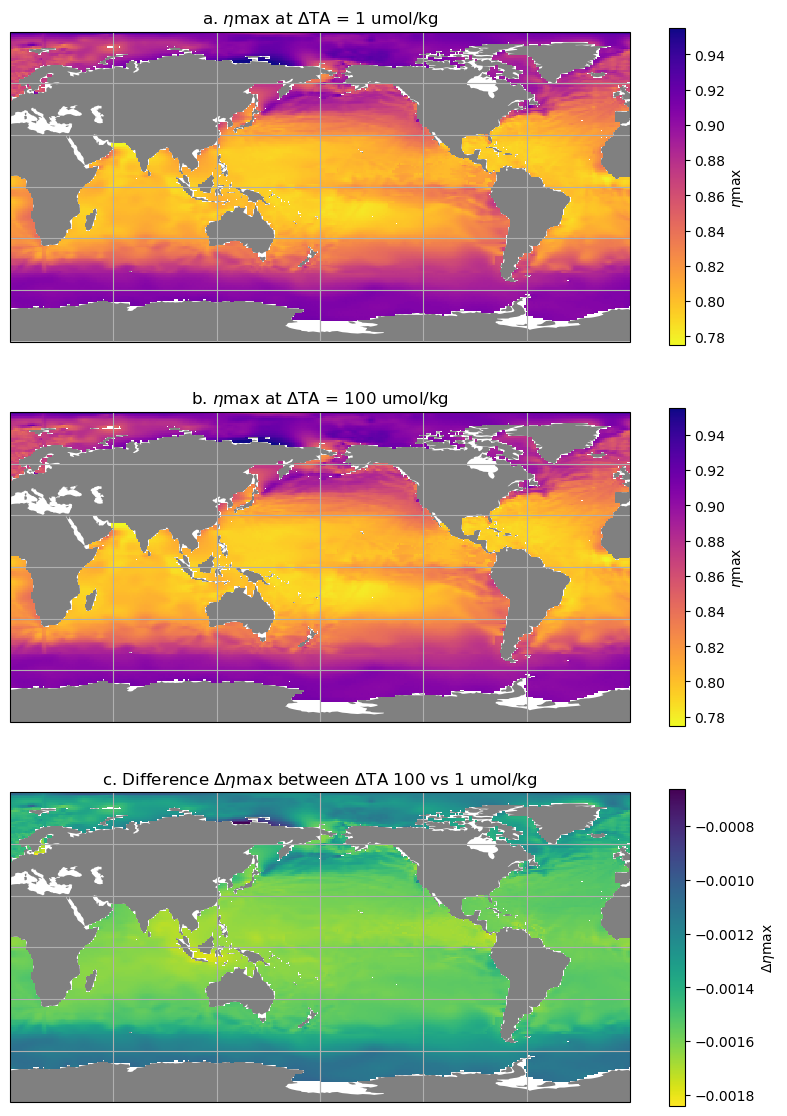

In [31]:
print('Plotting takes a few seconds, please wait ...')

fig, ax = plt.subplots(3, 1, figsize=(10, 14), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

lon = np.linspace(0.5, 359.5, 360)
lat = np.linspace(-89.5, 89.5, 180)
lon2d, lat2d = np.meshgrid(lon, lat)

# a. etamax assuming dTA = 1 umol/kg
data = result_dTA1["etamax"]
ax[0].set_title(r'a. $\eta$max at $\Delta$TA = 1 umol/kg')
ax[0].add_feature(cfeature.LAND, facecolor='gray')
# ax[0].coastlines('10m', edgecolor='none', linewidth=0.5)
# ax[0].add_feature(cfeature.BORDERS)
ax[0].gridlines()
cmap1 = plt.get_cmap('plasma').reversed()
contour1 = ax[0].pcolor(lon, lat, data, transform=ccrs.PlateCarree(), cmap=cmap1, vmin= 0.775, vmax=0.955)
cbar1 = plt.colorbar(contour1, orientation='vertical', pad=0.05)
cbar1.set_label(r'$\eta$max')

# b. etamax assuming dTA = 100 umol/kg
data = result_dTA100["etamax"]
ax[1].set_title(r'b. $\eta$max at $\Delta$TA = 100 umol/kg')
ax[1].add_feature(cfeature.LAND, facecolor='gray')
# ax[1].coastlines('10m', edgecolor='none', linewidth=0.5)
# ax[1].add_feature(cfeature.BORDERS, edgecolor='none')
ax[1].gridlines()
cmap2 = plt.get_cmap('plasma').reversed()
contour2 = ax[1].pcolor(lon, lat, data, transform=ccrs.PlateCarree(), cmap=cmap2, vmin= 0.775, vmax=0.955) 
cbar2 = plt.colorbar(contour2, orientation='vertical', pad=0.05)
cbar2.set_label(r'$\eta$max')

# c. Difference in etamax between dTA 100 vs 1 umol/kg
data = result_dTA100["etamax"] - result_dTA1["etamax"]
ax[2].set_title(r'c. Difference $\Delta\eta$max between $\Delta$TA 100 vs 1 umol/kg')
ax[2].add_feature(cfeature.LAND, facecolor='gray')
# ax[2].coastlines('10m', edgecolor='none', linewidth=0.5)
# ax[2].add_feature(cfeature.BORDERS, edgecolor='none')
ax[2].gridlines()
cmap3 = plt.get_cmap('viridis').reversed()
contour3 = ax[2].pcolor(lon, lat, data, transform=ccrs.PlateCarree(), cmap=cmap3)  
cbar3 = plt.colorbar(contour3, orientation='vertical', pad=0.05)
cbar3.set_label(r'$\Delta\eta$max')